# Dropout

In this notebook, you will implement dropout.  Then we will ask you to train a network with batchnorm and dropout, and acheive over 55% accuracy on CIFAR-10.

CS231n has built a solid API for building these modular frameworks and training them, and we will use their very well implemented framework as opposed to "reinventing the wheel."  This includes using their Solver, various utility functions, and their layer structure.  This also includes nndl.fc_net, nndl.layers, and nndl.layer_utils.  As in prior assignments, we thank Serena Yeung & Justin Johnson for permission to use code written for the CS 231n class (cs231n.stanford.edu).  

In [1]:
## Import and setups

import time
import numpy as np
import matplotlib.pyplot as plt
from nndl.fc_net import *
from nndl.layers import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k in data.keys():
    print('{}: {} '.format(k, data[k].shape))

X_train: (49000, 3, 32, 32) 
y_train: (49000,) 
X_val: (1000, 3, 32, 32) 
y_val: (1000,) 
X_test: (1000, 3, 32, 32) 
y_test: (1000,) 


## Dropout forward pass

Implement the training and test time dropout forward pass, `dropout_forward`, in `nndl/layers.py`. After that, test your implementation by running the following cell.

In [3]:
x = np.random.randn(500, 500) + 10

for p in [0.3, 0.6, 0.75]:
    out, _ = dropout_forward(x, {'mode': 'train', 'p': p})
    out_test, _ = dropout_forward(x, {'mode': 'test', 'p': p})

    print('Running tests with p = ', p)
    print('Mean of input: ', x.mean())
    print('Mean of train-time output: ', out.mean())
    print('Mean of test-time output: ', out_test.mean())
    print('Fraction of train-time output set to zero: ', (out == 0).mean())
    print('Fraction of test-time output set to zero: ', (out_test == 0).mean())

Running tests with p =  0.3
Mean of input:  10.000001382829788
Mean of train-time output:  9.97710869308702
Mean of test-time output:  10.000001382829788
Fraction of train-time output set to zero:  0.70062
Fraction of test-time output set to zero:  0.0
Running tests with p =  0.6
Mean of input:  10.000001382829788
Mean of train-time output:  9.990514111058806
Mean of test-time output:  10.000001382829788
Fraction of train-time output set to zero:  0.40064
Fraction of test-time output set to zero:  0.0
Running tests with p =  0.75
Mean of input:  10.000001382829788
Mean of train-time output:  9.989754158120473
Mean of test-time output:  10.000001382829788
Fraction of train-time output set to zero:  0.25068
Fraction of test-time output set to zero:  0.0


## Dropout backward pass

Implement the backward pass, `dropout_backward`, in `nndl/layers.py`.  After that, test your gradients by running the following cell:

In [9]:
x = np.random.randn(10, 10) + 10
dout = np.random.randn(*x.shape)

dropout_param = {'mode': 'train', 'p': 0.8, 'seed': 123}
out, cache = dropout_forward(x, dropout_param)
dx = dropout_backward(dout, cache)
dx_num = eval_numerical_gradient_array(lambda xx: dropout_forward(xx, dropout_param)[0], x, dout)

print('dx relative error: ', rel_error(dx, dx_num))

dx relative error:  5.4456087077504014e-11


## Implement a fully connected neural network with dropout layers

Modify the `FullyConnectedNet()` class in `nndl/fc_net.py` to incorporate dropout.  A dropout layer should be incorporated after every ReLU layer.  Concretely, there shouldn't be a dropout at the output layer since there is no ReLU at the output layer. You will need to modify the class in the following areas:

(1) In the forward pass, you will need to incorporate a dropout layer after every relu layer.

(2) In the backward pass, you will need to incorporate a dropout backward pass layer.

Check your implementation by running the following code.  Our W1 gradient relative error is on the order of 1e-6 (the largest of all the relative errors).

In [5]:
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for dropout in [0.5, 0.75, 1.0]:
    print('Running check with dropout = ', dropout)
    model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                              weight_scale=5e-2, dtype=np.float64,
                              dropout=dropout, seed=123)

    loss, grads = model.loss(X, y)
    print('Initial loss: ', loss)

    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
        print('{} relative error: {}'.format(name, rel_error(grad_num, grads[name])))
    print('\n')

Running check with dropout =  0.5
Initial loss:  2.295267975501856
W1 relative error: 2.0282047874084858e-07
W2 relative error: 4.047073918759975e-08
W3 relative error: 1.1644720400527794e-08
b1 relative error: 1.6039666201231794e-09
b2 relative error: 2.769898506881464e-09
b3 relative error: 7.246965093695343e-11


Running check with dropout =  0.75
Initial loss:  2.2994386210014763
W1 relative error: 3.325458090424239e-07
W2 relative error: 9.202023125069469e-08
W3 relative error: 8.349023357277793e-08
b1 relative error: 1.838170219710481e-08
b2 relative error: 6.305277445842512e-10
b3 relative error: 7.897779243404506e-11


Running check with dropout =  1.0
Initial loss:  2.300146023992476
W1 relative error: 2.887269159526911e-06
W2 relative error: 6.733806292036767e-07
W3 relative error: 4.156082874902751e-07
b1 relative error: 1.1981524078124987e-08
b2 relative error: 4.0997011259252865e-09
b3 relative error: 1.7921996302874612e-10




## Dropout as a regularizer

In class, we claimed that dropout acts as a regularizer by effectively bagging.  To check this, we will train two small networks, one with dropout and one without dropout.  

In [6]:
# Train two identical nets, one with dropout and one without

num_train = 500
small_data = {
    'X_train': data['X_train'][:num_train],
    'y_train': data['y_train'][:num_train],
    'X_val': data['X_val'],
    'y_val': data['y_val'],
}

solvers = {}
dropout_choices = [0.6, 1.0]
for dropout in dropout_choices:
    model = FullyConnectedNet([100, 100, 100], dropout=dropout)

    solver = Solver(model, small_data,
                    num_epochs=25, batch_size=100,
                    update_rule='adam',
                    optim_config={
                      'learning_rate': 5e-4,
                    },
                    verbose=True, print_every=100)
    solver.train()
    solvers[dropout] = solver

(Iteration 1 / 125) loss: 2.301155
(Epoch 0 / 25) train acc: 0.124000; val_acc: 0.115000
(Epoch 1 / 25) train acc: 0.184000; val_acc: 0.145000
(Epoch 2 / 25) train acc: 0.220000; val_acc: 0.174000
(Epoch 3 / 25) train acc: 0.262000; val_acc: 0.220000
(Epoch 4 / 25) train acc: 0.302000; val_acc: 0.273000
(Epoch 5 / 25) train acc: 0.306000; val_acc: 0.279000
(Epoch 6 / 25) train acc: 0.306000; val_acc: 0.234000
(Epoch 7 / 25) train acc: 0.352000; val_acc: 0.264000
(Epoch 8 / 25) train acc: 0.372000; val_acc: 0.286000
(Epoch 9 / 25) train acc: 0.442000; val_acc: 0.319000
(Epoch 10 / 25) train acc: 0.438000; val_acc: 0.314000
(Epoch 11 / 25) train acc: 0.450000; val_acc: 0.302000
(Epoch 12 / 25) train acc: 0.486000; val_acc: 0.298000
(Epoch 13 / 25) train acc: 0.522000; val_acc: 0.297000
(Epoch 14 / 25) train acc: 0.530000; val_acc: 0.310000
(Epoch 15 / 25) train acc: 0.524000; val_acc: 0.314000
(Epoch 16 / 25) train acc: 0.558000; val_acc: 0.317000
(Epoch 17 / 25) train acc: 0.600000; val

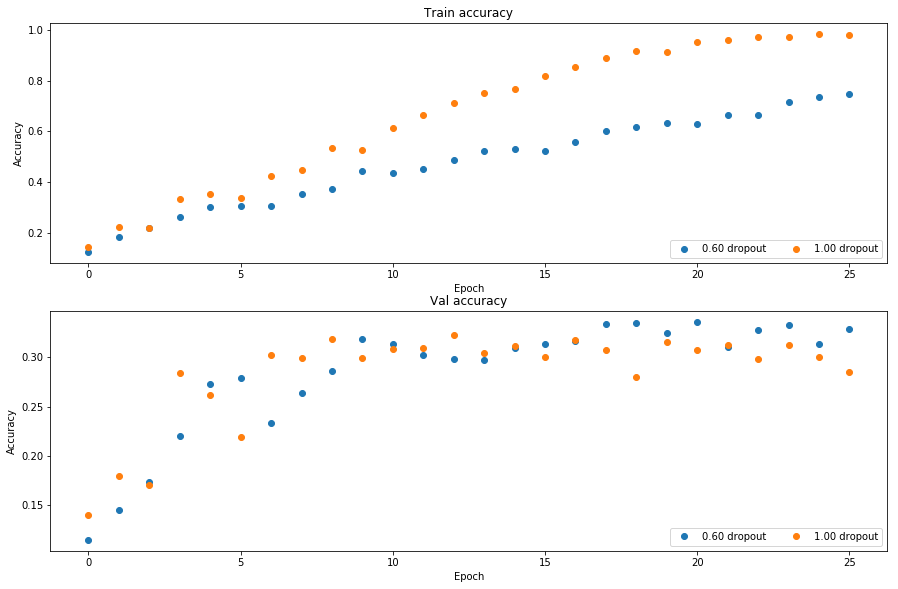

In [7]:
# Plot train and validation accuracies of the two models

train_accs = []
val_accs = []
for dropout in dropout_choices:
    solver = solvers[dropout]
    train_accs.append(solver.train_acc_history[-1])
    val_accs.append(solver.val_acc_history[-1])

plt.subplot(3, 1, 1)
for dropout in dropout_choices:
    plt.plot(solvers[dropout].train_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')
  
plt.subplot(3, 1, 2)
for dropout in dropout_choices:
    plt.plot(solvers[dropout].val_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(15, 15)
plt.show()

## Question

Based off the results of this experiment, is dropout performing regularization?  Explain your answer.

## Answer:
Yes this can be easily seen from the above graphs. When we do not do dropout ,which means p=1.00 since we are using inverted dropout, we end up getting 100% training accuracy. But when we do dropout p=0.6 we do not end up getting 100% training accuracy which show we are making regularization. This can be easily understood when we look at the both graphs. After some point we can observe from graphs that even if the training accuracy increases validation accuracy decreases when we do not do dropout. So this means that we are overfiting. But this does not occur when we do dropout. Which means we avoid overfitting. This means that we are making regularization. This can be understood from looking both graphs validation accuracies are close, however training accuracies are not which is also an indication that dropout is a regularization.


##### Final part of the assignment

Get over 55% validation accuracy on CIFAR-10 by using the layers you have implemented.  You will be graded according to the following equation:

min(floor((X - 32%)) / 23%, 1) 
where if you get 55% or higher validation accuracy, you get full points.

In [8]:
# ================================================================ #
# YOUR CODE HERE:
#   Implement a FC-net that achieves at least 55% validation accuracy
#   on CIFAR-10.
# ================================================================ #
model = FullyConnectedNet(hidden_dims=[600, 600, 600, 600], weight_scale=0.01, 
                          dropout= 0.55, use_batchnorm=True, reg=0.0)
solver = Solver(model, data,
              num_epochs=100, batch_size=100,
              update_rule='adam',
              optim_config={
                'learning_rate': 2e-3,
              },
              lr_decay=0.95,
              verbose=True, print_every=100)
solver.train()


# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #


(Iteration 1 / 49000) loss: 2.337209
(Epoch 0 / 100) train acc: 0.226000; val_acc: 0.209000
(Iteration 101 / 49000) loss: 1.909381
(Iteration 201 / 49000) loss: 1.991821
(Iteration 301 / 49000) loss: 1.706375
(Iteration 401 / 49000) loss: 1.614280
(Epoch 1 / 100) train acc: 0.469000; val_acc: 0.453000
(Iteration 501 / 49000) loss: 1.746416
(Iteration 601 / 49000) loss: 1.487279
(Iteration 701 / 49000) loss: 1.527817
(Iteration 801 / 49000) loss: 1.526194
(Iteration 901 / 49000) loss: 1.533760
(Epoch 2 / 100) train acc: 0.506000; val_acc: 0.488000
(Iteration 1001 / 49000) loss: 1.632138
(Iteration 1101 / 49000) loss: 1.290937
(Iteration 1201 / 49000) loss: 1.359080
(Iteration 1301 / 49000) loss: 1.398719
(Iteration 1401 / 49000) loss: 1.213827
(Epoch 3 / 100) train acc: 0.561000; val_acc: 0.511000
(Iteration 1501 / 49000) loss: 1.286829
(Iteration 1601 / 49000) loss: 1.440038
(Iteration 1701 / 49000) loss: 1.270594
(Iteration 1801 / 49000) loss: 1.205929
(Iteration 1901 / 49000) loss: 1

(Iteration 15801 / 49000) loss: 0.820418
(Iteration 15901 / 49000) loss: 0.894529
(Iteration 16001 / 49000) loss: 0.912454
(Iteration 16101 / 49000) loss: 0.856116
(Epoch 33 / 100) train acc: 0.784000; val_acc: 0.576000
(Iteration 16201 / 49000) loss: 0.999951
(Iteration 16301 / 49000) loss: 0.948048
(Iteration 16401 / 49000) loss: 0.895192
(Iteration 16501 / 49000) loss: 0.825491
(Iteration 16601 / 49000) loss: 0.817623
(Epoch 34 / 100) train acc: 0.770000; val_acc: 0.591000
(Iteration 16701 / 49000) loss: 1.160705
(Iteration 16801 / 49000) loss: 0.854678
(Iteration 16901 / 49000) loss: 1.221035
(Iteration 17001 / 49000) loss: 0.906017
(Iteration 17101 / 49000) loss: 0.779774
(Epoch 35 / 100) train acc: 0.810000; val_acc: 0.590000
(Iteration 17201 / 49000) loss: 0.912191
(Iteration 17301 / 49000) loss: 0.794138
(Iteration 17401 / 49000) loss: 0.764301
(Iteration 17501 / 49000) loss: 0.948792
(Iteration 17601 / 49000) loss: 0.851446
(Epoch 36 / 100) train acc: 0.799000; val_acc: 0.5860

(Iteration 31501 / 49000) loss: 0.794438
(Iteration 31601 / 49000) loss: 0.906233
(Iteration 31701 / 49000) loss: 0.937214
(Iteration 31801 / 49000) loss: 0.772743
(Epoch 65 / 100) train acc: 0.847000; val_acc: 0.603000
(Iteration 31901 / 49000) loss: 0.748661
(Iteration 32001 / 49000) loss: 0.754198
(Iteration 32101 / 49000) loss: 0.911973
(Iteration 32201 / 49000) loss: 0.780414
(Iteration 32301 / 49000) loss: 0.689910
(Epoch 66 / 100) train acc: 0.848000; val_acc: 0.603000
(Iteration 32401 / 49000) loss: 0.743287
(Iteration 32501 / 49000) loss: 0.862200
(Iteration 32601 / 49000) loss: 0.864878
(Iteration 32701 / 49000) loss: 0.734596
(Iteration 32801 / 49000) loss: 0.841265
(Epoch 67 / 100) train acc: 0.845000; val_acc: 0.598000
(Iteration 32901 / 49000) loss: 0.766045
(Iteration 33001 / 49000) loss: 0.799214
(Iteration 33101 / 49000) loss: 0.860673
(Iteration 33201 / 49000) loss: 0.726632
(Iteration 33301 / 49000) loss: 0.498721
(Epoch 68 / 100) train acc: 0.847000; val_acc: 0.6090

(Iteration 47201 / 49000) loss: 0.791190
(Iteration 47301 / 49000) loss: 0.822707
(Iteration 47401 / 49000) loss: 0.849706
(Iteration 47501 / 49000) loss: 0.851265
(Epoch 97 / 100) train acc: 0.850000; val_acc: 0.607000
(Iteration 47601 / 49000) loss: 0.866726
(Iteration 47701 / 49000) loss: 0.832352
(Iteration 47801 / 49000) loss: 0.700424
(Iteration 47901 / 49000) loss: 0.746417
(Iteration 48001 / 49000) loss: 0.646691
(Epoch 98 / 100) train acc: 0.841000; val_acc: 0.602000
(Iteration 48101 / 49000) loss: 0.766292
(Iteration 48201 / 49000) loss: 0.894268
(Iteration 48301 / 49000) loss: 0.837467
(Iteration 48401 / 49000) loss: 0.973584
(Iteration 48501 / 49000) loss: 1.061815
(Epoch 99 / 100) train acc: 0.839000; val_acc: 0.599000
(Iteration 48601 / 49000) loss: 0.819829
(Iteration 48701 / 49000) loss: 0.743849
(Iteration 48801 / 49000) loss: 0.859621
(Iteration 48901 / 49000) loss: 0.621001
(Epoch 100 / 100) train acc: 0.859000; val_acc: 0.607000


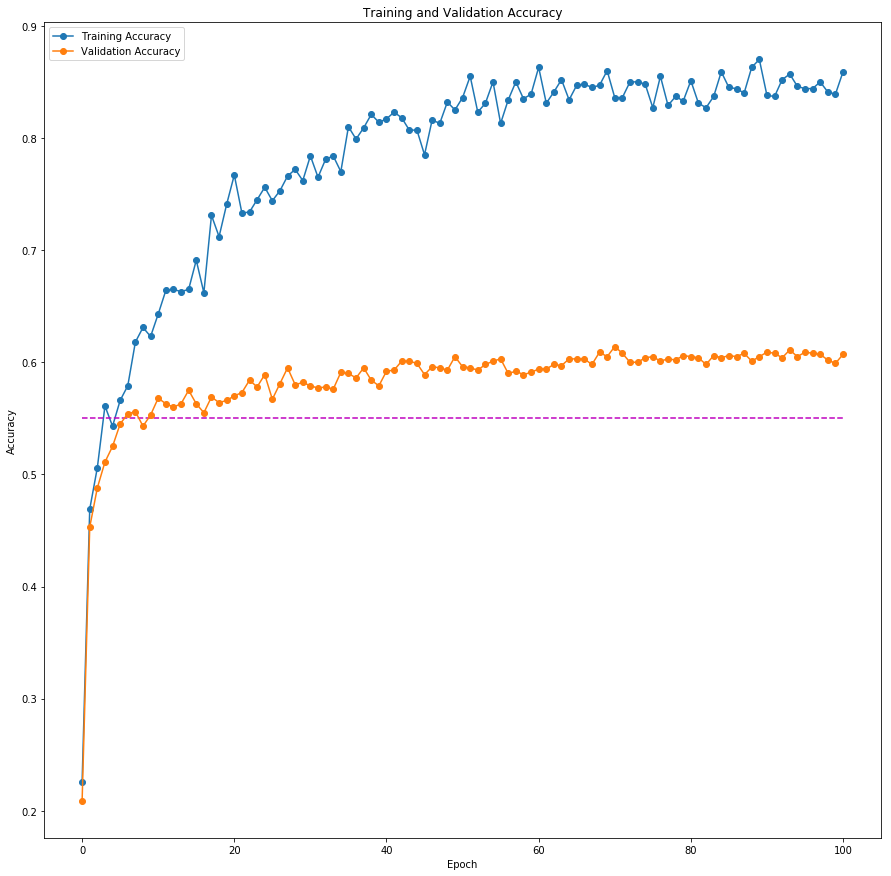

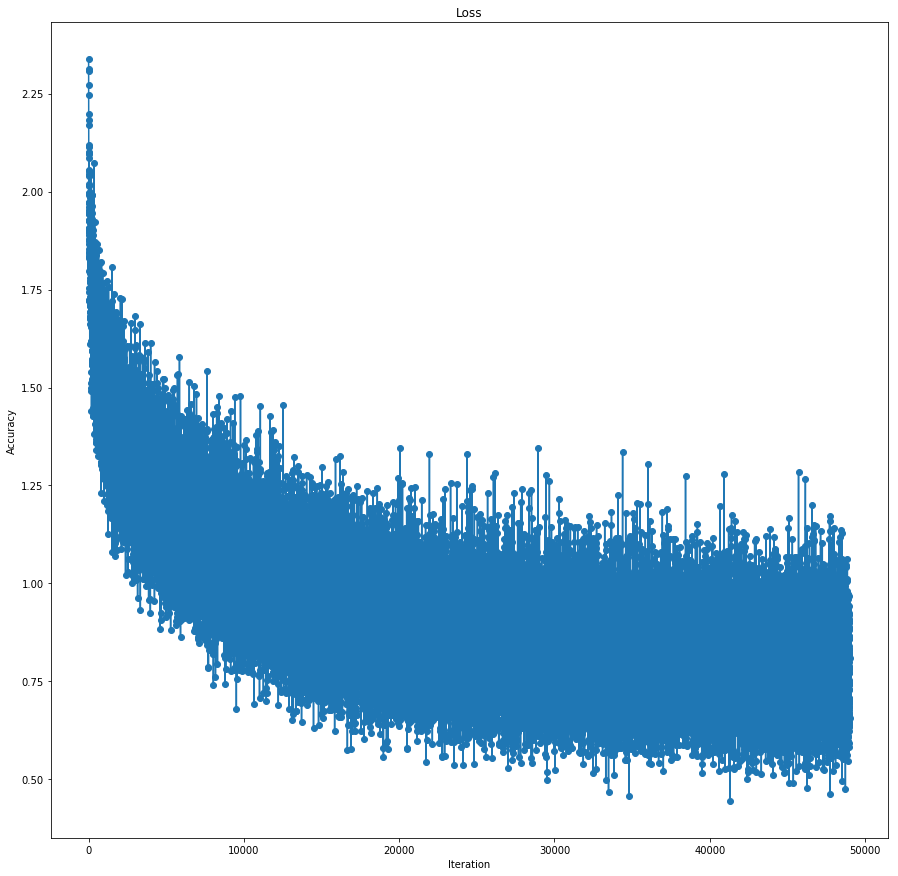

In [22]:
train_accs = []
val_accs = []

solver.train_acc_history
solver.val_acc_history



plt.plot(solver.train_acc_history, '-o',label='Training Accuracy')
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

  
border=np.array([0.55 for i in range(len(solver.train_acc_history))])
plt.plot(border, 'm--')

plt.plot(solver.val_acc_history, '-o',label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.gcf().set_size_inches(15,15)
plt.show()

plt.plot(solver.loss_history, '-o')
plt.title('Loss')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.gcf().set_size_inches(15,15)
plt.show()





In [ ]:
import numpy as np
import pdb

from .layers import *
from .layer_utils import *

""" 
This code was originally written for CS 231n at Stanford University
(cs231n.stanford.edu).  It has been modified in various areas for use in the
ECE 239AS class at UCLA.  This includes the descriptions of what code to
implement as well as some slight potential changes in variable names to be
consistent with class nomenclature.  We thank Justin Johnson & Serena Yeung for
permission to use this code.  To see the original version, please visit
cs231n.stanford.edu.  
"""

class TwoLayerNet(object):
    """
    A two-layer fully-connected neural network with ReLU nonlinearity and
    softmax loss that uses a modular layer design. We assume an input dimension
    of D, a hidden dimension of H, and perform classification over C classes.
    
    The architecure should be affine - relu - affine - softmax.

    Note that this class does not implement gradient descent; instead, it
    will interact with a separate Solver object that is responsible for running
    optimization.

    The learnable parameters of the model are stored in the dictionary
    self.params that maps parameter names to numpy arrays.
    """
    
    def __init__(self, input_dim=3*32*32, hidden_dims=100, num_classes=10,
                 dropout=0, weight_scale=1e-3, reg=0.0):
        """
        Initialize a new network.

        Inputs:
        - input_dim: An integer giving the size of the input
        - hidden_dims: An integer giving the size of the hidden layer
        - num_classes: An integer giving the number of classes to classify
        - dropout: Scalar between 0 and 1 giving dropout strength.
        - weight_scale: Scalar giving the standard deviation for random
          initialization of the weights.
        - reg: Scalar giving L2 regularization strength.
        """
        self.params = {}
        self.reg = reg
        
        # ================================================================ #
        # YOUR CODE HERE:
        #   Initialize W1, W2, b1, and b2.  Store these as self.params['W1'], 
        #   self.params['W2'], self.params['b1'] and self.params['b2']. The
        #   biases are initialized to zero and the weights are initialized
        #   so that each parameter has mean 0 and standard deviation weight_scale.
        #   The dimensions of W1 should be (input_dim, hidden_dim) and the
        #   dimensions of W2 should be (hidden_dims, num_classes)
        # ================================================================ #


        # ================================================================ #
        # END YOUR CODE HERE
        # ================================================================ #

    def loss(self, X, y=None):
        """
        Compute loss and gradient for a minibatch of data.

        Inputs:
        - X: Array of input data of shape (N, d_1, ..., d_k)
        - y: Array of labels, of shape (N,). y[i] gives the label for X[i].

        Returns:
        If y is None, then run a test-time forward pass of the model and return:
        - scores: Array of shape (N, C) giving classification scores, where
          scores[i, c] is the classification score for X[i] and class c.

        If y is not None, then run a training-time forward and backward pass and
        return a tuple of:
        - loss: Scalar value giving the loss
        - grads: Dictionary with the same keys as self.params, mapping parameter
          names to gradients of the loss with respect to those parameters.
        """  
        scores = None

        # ================================================================ #
        # YOUR CODE HERE:
        #   Implement the forward pass of the two-layer neural network. Store
        #   the class scores as the variable 'scores'.  Be sure to use the layers
        #   you prior implemented.
        # ================================================================ #    
        
        # ================================================================ #
        # END YOUR CODE HERE
        # ================================================================ #
        
        # If y is None then we are in test mode so just return scores
        if y is None:
            return scores
        
        loss, grads = 0, {}
        # ================================================================ #
        # YOUR CODE HERE:
        #   Implement the backward pass of the two-layer neural net.  Store
        #   the loss as the variable 'loss' and store the gradients in the 
        #   'grads' dictionary.  For the grads dictionary, grads['W1'] holds
        #   the gradient for W1, grads['b1'] holds the gradient for b1, etc.
        #   i.e., grads[k] holds the gradient for self.params[k].
        #
        #   Add L2 regularization, where there is an added cost 0.5*self.reg*W^2
        #   for each W.  Be sure to include the 0.5 multiplying factor to 
        #   match our implementation.
        #
        #   And be sure to use the layers you prior implemented.
        # ================================================================ #    
        
        # ================================================================ #
        # END YOUR CODE HERE
        # ================================================================ #
        
        return loss, grads


class FullyConnectedNet(object):
  """
  A fully-connected neural network with an arbitrary number of hidden layers,
  ReLU nonlinearities, and a softmax loss function. This will also implement
  dropout and batch normalization as options. For a network with L layers,
  the architecture will be
  
  {affine - [batch norm] - relu - [dropout]} x (L - 1) - affine - softmax
  
  where batch normalization and dropout are optional, and the {...} block is
  repeated L - 1 times.
  
  Similar to the TwoLayerNet above, learnable parameters are stored in the
  self.params dictionary and will be learned using the Solver class.
  """

  def __init__(self, hidden_dims, input_dim=3*32*32, num_classes=10,
               dropout=0, use_batchnorm=False, reg=0.0,
               weight_scale=1e-2, dtype=np.float32, seed=None):
    """
    Initialize a new FullyConnectedNet.
    
    Inputs:
    - hidden_dims: A list of integers giving the size of each hidden layer.
    - input_dim: An integer giving the size of the input.
    - num_classes: An integer giving the number of classes to classify.
    - dropout: Scalar between 0 and 1 giving dropout strength. If dropout=0 then
      the network should not use dropout at all.
    - use_batchnorm: Whether or not the network should use batch normalization.
    - reg: Scalar giving L2 regularization strength.
    - weight_scale: Scalar giving the standard deviation for random
      initialization of the weights.
    - dtype: A numpy datatype object; all computations will be performed using
      this datatype. float32 is faster but less accurate, so you should use
      float64 for numeric gradient checking.
    - seed: If not None, then pass this random seed to the dropout layers. This
      will make the dropout layers deteriminstic so we can gradient check the
      model.
    """
    self.use_batchnorm = use_batchnorm
    self.use_dropout = dropout > 0
    self.reg = reg
    self.num_layers = 1 + len(hidden_dims)
    self.dtype = dtype
    self.hidden_dims=hidden_dims
    self.params = {}

    # ================================================================ #
    # YOUR CODE HERE:
    #   Initialize all parameters of the network in the self.params dictionary.
    #   The weights and biases of layer 1 are W1 and b1; and in general the 
    #   weights and biases of layer i are Wi and bi. The
    #   biases are initialized to zero and the weights are initialized
    #   so that each parameter has mean 0 and standard deviation weight_scale.
    # ================================================================ #
    
    self.params['W'+str(1)]=weight_scale*np.random.randn(input_dim,hidden_dims[0])
    self.params['b'+str(1)]=np.zeros(hidden_dims[0])
    self.params['W'+str(len(hidden_dims)+1)]=weight_scale*np.random.randn(hidden_dims[len(hidden_dims)-1],num_classes)
    self.params['b'+str(len(hidden_dims)+1)]=np.zeros(num_classes)
    if(use_batchnorm):
            self.params['gamma'+str(1)]=np.ones(hidden_dims[0])
            self.params['beta'+str(1)]=np.zeros(hidden_dims[0])
    for i in range(len(hidden_dims)-1):
            self.params['W'+str(i+2)]=weight_scale*np.random.randn(hidden_dims[i],hidden_dims[i+1])
            self.params['b'+str(i+2)]=np.zeros(hidden_dims[i+1])
            if(use_batchnorm):
                self.params['gamma'+str(i+2)]=np.ones(hidden_dims[i+1])
                self.params['beta'+str(i+2)]=np.zeros(hidden_dims[i+1])
        
    
    pass

    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #
    
    # When using dropout we need to pass a dropout_param dictionary to each
    # dropout layer so that the layer knows the dropout probability and the mode
    # (train / test). You can pass the same dropout_param to each dropout layer.
    self.dropout_param = {}
    if self.use_dropout:
      self.dropout_param = {'mode': 'train', 'p': dropout}
      if seed is not None:
        self.dropout_param['seed'] = seed
    
    # With batch normalization we need to keep track of running means and
    # variances, so we need to pass a special bn_param object to each batch
    # normalization layer. You should pass self.bn_params[0] to the forward pass
    # of the first batch normalization layer, self.bn_params[1] to the forward
    # pass of the second batch normalization layer, etc.
    self.bn_params = []
    if self.use_batchnorm:
      self.bn_params = [{'mode': 'train'} for i in np.arange(self.num_layers - 1)]
    
    # Cast all parameters to the correct datatype
    for k, v in self.params.items():
      self.params[k] = v.astype(dtype)


  def loss(self, X, y=None):
    """
    Compute loss and gradient for the fully-connected net.

    Input / output: Same as TwoLayerNet above.
    """
    X = X.astype(self.dtype)
    mode = 'test' if y is None else 'train'

    # Set train/test mode for batchnorm params and dropout param since they
    # behave differently during training and testing.
    if self.dropout_param is not None:
      self.dropout_param['mode'] = mode   
    if self.use_batchnorm:
      for bn_param in self.bn_params:
        bn_param[mode] = mode

    scores = None
    
    
    
    # ================================================================ #
    # YOUR CODE HERE:
    #   Implement the forward pass of the FC net and store the output
    #   scores as the variable "scores".
    # ================================================================ #
    diccache = {}
    diccacherel={}
    diccachebatch={}
    dicdropcache={}
    
    out, kes=affine_forward(X,self.params['W1'],self.params['b1'])
    if(self.use_batchnorm):
        out,diccachebatch['X1']=batchnorm_forward(out, self.params['gamma'+str(1)], self.params['beta'+str(1)], self.bn_params[0])
    out,diccacherel['X1']=relu_forward(out)
    if(self.use_dropout ):
        out,dicdropcache['X1']=dropout_forward(out, self.dropout_param)
    diccache['X1']=kes
    
    #print(X.shape)
    #print(out.shape)
    #print(self.params['W2'].shape)
    temp=out
    
    for i in range (len(self.hidden_dims)-1):
        out, kes=affine_forward(temp,self.params['W'+str(i+2)],self.params['b'+str(i+2)])
        diccache['X'+str(i+2)]=kes
        if(self.use_batchnorm):
            out,diccachebatch['X'+str(i+2)]=batchnorm_forward(out, self.params['gamma'+str(i+2)], self.params['beta'+str(i+2)], self.bn_params[i+1])
        temp,kes=relu_forward(out)
        if(self.use_dropout ):
            temp,dicdropcache['X'+str(i+2)]=dropout_forward(temp,self.dropout_param)
        diccacherel['X'+str(i+2)]=kes
    out, kes=affine_forward(temp,self.params['W'+str(len(self.hidden_dims)+1)],self.params['b'+str(len(self.hidden_dims)+1)])
    diccache['X'+str(len(self.hidden_dims)+1)]=kes
    scores=out
    loss,dx=softmax_loss(out, y)
    for i in range (len(self.hidden_dims)+1):
        loss=loss+self.reg*0.5*np.sum(self.params['W'+str(i+1)]**2)
    
    #print(loss)

    pass

    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #
    
    # If test mode return early
    if mode == 'test':
      return scores

    loss, grads = loss, {}
    # ================================================================ #
    # YOUR CODE HERE:
    #   Implement the backwards pass of the FC net and store the gradients
    #   in the grads dict, so that grads[k] is the gradient of self.params[k]
    #   Be sure your L2 regularization includes a 0.5 factor.
    # ================================================================ #
    dout=dx
    
    dout,grads['W'+str(len(self.hidden_dims)+1)],grads['b'+str(len(self.hidden_dims)+1)]=affine_backward(dout, diccache['X'+str(len(self.hidden_dims)+1)])
    grads['W'+str(len(self.hidden_dims)+1)]=grads['W'+str(len(self.hidden_dims)+1)]+self.reg*self.params['W'+str(len(self.hidden_dims)+1)]
    #grads['W'+len(self.hidden_dims)+1]=dx
    for i in range(len(self.hidden_dims),1,-1):
        if (self.use_batchnorm):
            #dout=dropout_backward(dout, dicdropcache['X'+str(i)])
            dout=relu_backward(dout, diccacherel['X'+str(i)])
            dout, grads['gamma'+str(i)], grads['beta'+str(i)]=batchnorm_backward(dout,diccachebatch['X'+str(i)])
            dout,grads['W'+str(i)],grads['b'+str(i)]=affine_backward(dout, diccache['X'+str(i)])
            grads['W'+str(i)]=grads['W'+str(i)]+self.reg*self.params['W'+str(i)]
            
        else:
            if(self.use_dropout ):
                dout=dropout_backward(dout, dicdropcache['X'+str(i)])
            dout=relu_backward(dout, diccacherel['X'+str(i)])
            dout,grads['W'+str(i)],grads['b'+str(i)]=affine_backward(dout, diccache['X'+str(i)])
            grads['W'+str(i)]=grads['W'+str(i)]+self.reg*self.params['W'+str(i)]
    if (self.use_batchnorm):
        #dout=dropout_backward(dout, dicdropcache['X1'])
        dout=relu_backward(dout, diccacherel['X1'])
        dout, grads['gamma1'], grads['beta1']=batchnorm_backward(dout,diccachebatch['X1'])
        dout,grads['W1'],grads['b1']=affine_backward(dout, diccache['X1']) 
        grads['W1']=grads['W1']+self.reg*self.params['W1']
        
    else:
        if(self.use_dropout ):
            dout=dropout_backward(dout, dicdropcache['X1'])
        dout=relu_backward(dout, diccacherel['X1'])
        dout,grads['W1'],grads['b1']=affine_backward(dout, diccache['X1']) 
        grads['W1']=grads['W1']+self.reg*self.params['W1']
        

    pass

    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #
    return loss, grads
################################################################
    ###############################
    ############################
    ##############
import numpy as np
import pdb

""" 
This code was originally written for CS 231n at Stanford University
(cs231n.stanford.edu).  It has been modified in various areas for use in the
ECE 239AS class at UCLA.  This includes the descriptions of what code to
implement as well as some slight potential changes in variable names to be
consistent with class nomenclature.  We thank Justin Johnson & Serena Yeung for
permission to use this code.  To see the original version, please visit
cs231n.stanford.edu.  
"""

def affine_forward(x, w, b):
    """
    Computes the forward pass for an affine (fully-connected) layer.

    The input x has shape (N, d_1, ..., d_k) and contains a minibatch of N
    examples, where each example x[i] has shape (d_1, ..., d_k). We will
    reshape each input into a vector of dimension D = d_1 * ... * d_k, and
    then transform it to an output vector of dimension M.

    Inputs:
    - x: A numpy array containing input data, of shape (N, d_1, ..., d_k)
    - w: A numpy array of weights, of shape (D, M)
    - b: A numpy array of biases, of shape (M,)
    
    Returns a tuple of:
    - out: output, of shape (N, M)
    - cache: (x, w, b)
    """
    out = None
    # ================================================================ #
    # YOUR CODE HERE:
    #   Calculate the output of the forward pass.  Notice the dimensions
    #   of w are D x M, which is the transpose of what we did in earlier 
    #   assignments.
    # ================================================================ #
    
    out=np.dot(x.reshape(x.shape[0], -1),w)+b

    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #
      
    cache = (x, w, b)
    return out, cache


def affine_backward(dout, cache):
    """
    Computes the backward pass for an affine layer.

    Inputs:
    - dout: Upstream derivative, of shape (N, M)
    - cache: Tuple of:
      - x: A numpy array containing input data, of shape (N, d_1, ..., d_k)
      - w: A numpy array of weights, of shape (D, M)
      - b: A numpy array of biases, of shape (M,)

    Returns a tuple of:
    - dx: Gradient with respect to x, of shape (N, d1, ..., d_k)
    - dw: Gradient with respect to w, of shape (D, M)
    - db: Gradient with respect to b, of shape (M,)
    """
    x, w, b = cache
    dx, dw, db = None, None, None

    # ================================================================ #
    # YOUR CODE HERE:
    #   Calculate the gradients for the backward pass.
    # Notice:  
    #   dout is N x M
    #   dx should be N x d1 x ... x dk; it relates to dout through multiplication with w, which is D x M
    #   dw should be D x M; it relates to dout through multiplication with x, which is N x D after reshaping
    #   db should be M; it is just the sum over dout examples
    # ================================================================ #

    dx=np.dot(dout,w.T).reshape(x.shape)
    dw=np.dot(x.reshape(x.shape[0], -1).T,dout)
    db=np.sum(dout,axis=0)
    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #
    
    return dx, dw, db

def relu_forward(x):
    """
    Computes the forward pass for a layer of rectified linear units (ReLUs).

    Input:
    - x: Inputs, of any shape

    Returns a tuple of:
    - out: Output, of the same shape as x
    - cache: x
    """
    # ================================================================ #
    # YOUR CODE HERE:
    #   Implement the ReLU forward pass.
    # ================================================================ #
    out=x*(x>0)
    cache = x
    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #
    
    cache = x
    return out, cache


def relu_backward(dout, cache):
    """
    Computes the backward pass for a layer of rectified linear units (ReLUs).

    Input:
    - dout: Upstream derivatives, of any shape
    - cache: Input x, of same shape as dout

    Returns:
    - dx: Gradient with respect to x
    """
    x = cache

    # ================================================================ #
    # YOUR CODE HERE:
    #   Implement the ReLU backward pass
    # ================================================================ #
    dx=np.ones(x.shape)*(x>0)
    dx=dx*dout
    
    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #
    
    return dx

def batchnorm_forward(x, gamma, beta, bn_param):
    """
    Forward pass for batch normalization.
    
    During training the sample mean and (uncorrected) sample variance are
    computed from minibatch statistics and used to normalize the incoming data.
    During training we also keep an exponentially decaying running mean of the mean
    and variance of each feature, and these averages are used to normalize data
    at test-time.

    At each timestep we update the running averages for mean and variance using
    an exponential decay based on the momentum parameter:

    running_mean = momentum * running_mean + (1 - momentum) * sample_mean
    running_var = momentum * running_var + (1 - momentum) * sample_var

    Note that the batch normalization paper suggests a different test-time
    behavior: they compute sample mean and variance for each feature using a
    large number of training images rather than using a running average. For
    this implementation we have chosen to use running averages instead since
    they do not require an additional estimation step; the torch7 implementation
    of batch normalization also uses running averages.

    Input:
    - x: Data of shape (N, D)
    - gamma: Scale parameter of shape (D,)
    - beta: Shift paremeter of shape (D,)
    - bn_param: Dictionary with the following keys:
      - mode: 'train' or 'test'; required
      - eps: Constant for numeric stability
      - momentum: Constant for running mean / variance.
      - running_mean: Array of shape (D,) giving running mean of features
      - running_var Array of shape (D,) giving running variance of features

    Returns a tuple of:
    - out: of shape (N, D)
    - cache: A tuple of values needed in the backward pass
    """
    mode = bn_param['mode']
    eps = bn_param.get('eps', 1e-5)
    momentum = bn_param.get('momentum', 0.9)

    N, D = x.shape
    running_mean = bn_param.get('running_mean', np.zeros(D, dtype=x.dtype))
    running_var = bn_param.get('running_var', np.zeros(D, dtype=x.dtype))

    out, cache = None, None
    if mode == 'train':
        
        # ================================================================ #
        # YOUR CODE HERE:
        #   A few steps here:
        #     (1) Calculate the running mean and variance of the minibatch.
        #     (2) Normalize the activations with the running mean and variance.
        #     (3) Scale and shift the normalized activations.  Store this
        #         as the variable 'out'
        #     (4) Store any variables you may need for the backward pass in
        #         the 'cache' variable.
        # ================================================================ #
        temp_x=x
        sample_mean=np.mean(x,axis=0)
        sample_var=np.var(x,axis=0)
        running_mean = momentum * running_mean + (1 - momentum) * sample_mean
        running_var = momentum * running_var + (1 - momentum) * sample_var
        a=(x-sample_mean)
        e=sample_var+eps
        c=np.sqrt(e)
        b=1/c
        x_hat=a*b
        x=(x-sample_mean)/np.sqrt(sample_var+eps)
        x=x*gamma+beta
        out=x
        cache=x_hat,gamma,sample_var,sample_mean,eps,temp_x
        pass

        # ================================================================ #
        # END YOUR CODE HERE
        # ================================================================ #
    elif mode == 'test':
        # ================================================================ #
        # YOUR CODE HERE:
        #   Calculate the testing time normalized activation.  Normalize using
        #   the running mean and variance, and then scale and shift appropriately.
        #   Store the output as 'out'.
        # ================================================================ #
        x=(x-running_mean)/np.sqrt(running_var+eps)
        x=x*gamma+beta
        out=x
        pass
        
        # ================================================================ #
        # END YOUR CODE HERE
        # ================================================================ #
    else:
        raise ValueError('Invalid forward batchnorm mode "%s"' % mode)

    # Store the updated running means back into bn_param
    bn_param['running_mean'] = running_mean
    bn_param['running_var'] = running_var

    return out, cache

def batchnorm_backward(dout, cache):
    """
    Backward pass for batch normalization.
    
    For this implementation, you should write out a computation graph for
    batch normalization on paper and propagate gradients backward through
    intermediate nodes.
    
    Inputs:
    - dout: Upstream derivatives, of shape (N, D)
    - cache: Variable of intermediates from batchnorm_forward.
    
    Returns a tuple of:
    - dx: Gradient with respect to inputs x, of shape (N, D)
    - dgamma: Gradient with respect to scale parameter gamma, of shape (D,)
    - dbeta: Gradient with respect to shift parameter beta, of shape (D,)
    """
    dx, dgamma, dbeta = None, None, None
    
    # ================================================================ #
    # YOUR CODE HERE:
    #   Implement the batchnorm backward pass, calculating dx, dgamma, and dbeta.
    # ================================================================ #
    x_hat,gamma,sample_var,sample_mean,eps,x=cache
    dbeta=dout.sum(axis=0)
    dgamma=(dout*x_hat).sum(axis=0)
    dx_hat=dout*gamma
    da=(1/np.sqrt(sample_var+eps))*dx_hat
    db=(x-sample_mean)*dx_hat
    dc=(-1/(sample_var+eps))*db
    de=0.5*((1/np.sqrt(sample_var+eps)))*dc
    dvar=de.sum(axis=0)
    dmu=-da.sum(axis=0)-dvar*(2/x.shape[0])*((x-sample_mean).sum(axis=0))
    dx=(1/np.sqrt(sample_var+eps))*dx_hat+(2*(x-sample_mean)/x.shape[0])*dvar+dmu/x.shape[0]
    
    
    
    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #
    
    return dx, dgamma, dbeta

def dropout_forward(x, dropout_param):
    """
    Performs the forward pass for (inverted) dropout.

    Inputs:
    - x: Input data, of any shape
    - dropout_param: A dictionary with the following keys:
      - p: Dropout parameter. We keep each neuron output with probability p.
      - mode: 'test' or 'train'. If the mode is train, then perform dropout;
        if the mode is test, then just return the input.
      - seed: Seed for the random number generator. Passing seed makes this
        function deterministic, which is needed for gradient checking but not in
        real networks.

    Outputs:
    - out: Array of the same shape as x.
    - cache: A tuple (dropout_param, mask). In training mode, mask is the dropout
      mask that was used to multiply the input; in test mode, mask is None.
    """
    p, mode = dropout_param['p'], dropout_param['mode']
    if 'seed' in dropout_param:
        np.random.seed(dropout_param['seed'])

    mask = None
    out = None

    if mode == 'train':
        # ================================================================ #
        # YOUR CODE HERE:
        #   Implement the inverted dropout forward pass during training time.  
        #   Store the masked and scaled activations in out, and store the 
        #   dropout mask as the variable mask.
        # ================================================================ #
        mask=(np.random.rand(*x.shape)<p)/p
        x=mask*x
        out=x
        
        
        pass
        # ================================================================ #
        # END YOUR CODE HERE
        # ================================================================ #
    
    elif mode == 'test':
        
        # ================================================================ #
        # YOUR CODE HERE:
        #   Implement the inverted dropout forward pass during test time.
        # ================================================================ #
        out=x
        
        pass
        # ================================================================ #
        # END YOUR CODE HERE
        # ================================================================ #

    cache = (dropout_param, mask)
    out = out.astype(x.dtype, copy=False)

    return out, cache

def dropout_backward(dout, cache):
    """
    Perform the backward pass for (inverted) dropout.

    Inputs:
    - dout: Upstream derivatives, of any shape
    - cache: (dropout_param, mask) from dropout_forward.
    """
    dropout_param, mask = cache
    mode = dropout_param['mode']
    
    dx = None
    if mode == 'train':
        # ================================================================ #
        # YOUR CODE HERE:
        #   Implement the inverted dropout backward pass during training time.
        # ================================================================ #
        
        dx=mask*dout
        
        
        pass
        # ================================================================ #
        # END YOUR CODE HERE
        # ================================================================ #
    elif mode == 'test':
        # ================================================================ #
        # YOUR CODE HERE:
        #   Implement the inverted dropout backward pass during test time.
        # ================================================================ #
        dx=dout
        
        pass
        # ================================================================ #
        # END YOUR CODE HERE
        # ================================================================ #
    return dx

def svm_loss(x, y):
    """
    Computes the loss and gradient using for multiclass SVM classification.

    Inputs:
    - x: Input data, of shape (N, C) where x[i, j] is the score for the jth class
      for the ith input.
    - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
      0 <= y[i] < C

    Returns a tuple of:
    - loss: Scalar giving the loss
    - dx: Gradient of the loss with respect to x
    """
    N = x.shape[0]
    correct_class_scores = x[np.arange(N), y]
    margins = np.maximum(0, x - correct_class_scores[:, np.newaxis] + 1.0)
    margins[np.arange(N), y] = 0
    loss = np.sum(margins) / N
    num_pos = np.sum(margins > 0, axis=1)
    dx = np.zeros_like(x)
    dx[margins > 0] = 1
    dx[np.arange(N), y] -= num_pos
    dx /= N
    return loss, dx


def softmax_loss(x, y):
    """
    Computes the loss and gradient for softmax classification.

    Inputs:
    - x: Input data, of shape (N, C) where x[i, j] is the score for the jth class
      for the ith input.
    - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
      0 <= y[i] < C

    Returns a tuple of:
    - loss: Scalar giving the loss
    - dx: Gradient of the loss with respect to x
    """

    probs = np.exp(x - np.max(x, axis=1, keepdims=True))
    probs /= np.sum(probs, axis=1, keepdims=True)
    N = x.shape[0]
    probs[probs<1e-10]=1e-10
    loss = -np.sum(np.log(probs[np.arange(N), y])) / N
    dx = probs.copy()
    dx[np.arange(N), y] -= 1
    dx /= N
    return loss, dx



In [ ]:
import numpy as np
import pdb

""" 
This code was originally written for CS 231n at Stanford University
(cs231n.stanford.edu).  It has been modified in various areas for use in the
ECE 239AS class at UCLA.  This includes the descriptions of what code to
implement as well as some slight potential changes in variable names to be
consistent with class nomenclature.  We thank Justin Johnson & Serena Yeung for
permission to use this code.  To see the original version, please visit
cs231n.stanford.edu.  
"""

def affine_forward(x, w, b):
    """
    Computes the forward pass for an affine (fully-connected) layer.

    The input x has shape (N, d_1, ..., d_k) and contains a minibatch of N
    examples, where each example x[i] has shape (d_1, ..., d_k). We will
    reshape each input into a vector of dimension D = d_1 * ... * d_k, and
    then transform it to an output vector of dimension M.

    Inputs:
    - x: A numpy array containing input data, of shape (N, d_1, ..., d_k)
    - w: A numpy array of weights, of shape (D, M)
    - b: A numpy array of biases, of shape (M,)
    
    Returns a tuple of:
    - out: output, of shape (N, M)
    - cache: (x, w, b)
    """
    out = None
    # ================================================================ #
    # YOUR CODE HERE:
    #   Calculate the output of the forward pass.  Notice the dimensions
    #   of w are D x M, which is the transpose of what we did in earlier 
    #   assignments.
    # ================================================================ #
    
    out=np.dot(x.reshape(x.shape[0], -1),w)+b

    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #
      
    cache = (x, w, b)
    return out, cache


def affine_backward(dout, cache):
    """
    Computes the backward pass for an affine layer.

    Inputs:
    - dout: Upstream derivative, of shape (N, M)
    - cache: Tuple of:
      - x: A numpy array containing input data, of shape (N, d_1, ..., d_k)
      - w: A numpy array of weights, of shape (D, M)
      - b: A numpy array of biases, of shape (M,)

    Returns a tuple of:
    - dx: Gradient with respect to x, of shape (N, d1, ..., d_k)
    - dw: Gradient with respect to w, of shape (D, M)
    - db: Gradient with respect to b, of shape (M,)
    """
    x, w, b = cache
    dx, dw, db = None, None, None

    # ================================================================ #
    # YOUR CODE HERE:
    #   Calculate the gradients for the backward pass.
    # Notice:  
    #   dout is N x M
    #   dx should be N x d1 x ... x dk; it relates to dout through multiplication with w, which is D x M
    #   dw should be D x M; it relates to dout through multiplication with x, which is N x D after reshaping
    #   db should be M; it is just the sum over dout examples
    # ================================================================ #

    dx=np.dot(dout,w.T).reshape(x.shape)
    dw=np.dot(x.reshape(x.shape[0], -1).T,dout)
    db=np.sum(dout,axis=0)
    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #
    
    return dx, dw, db

def relu_forward(x):
    """
    Computes the forward pass for a layer of rectified linear units (ReLUs).

    Input:
    - x: Inputs, of any shape

    Returns a tuple of:
    - out: Output, of the same shape as x
    - cache: x
    """
    # ================================================================ #
    # YOUR CODE HERE:
    #   Implement the ReLU forward pass.
    # ================================================================ #
    out=x*(x>0)
    cache = x
    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #
    
    cache = x
    return out, cache


def relu_backward(dout, cache):
    """
    Computes the backward pass for a layer of rectified linear units (ReLUs).

    Input:
    - dout: Upstream derivatives, of any shape
    - cache: Input x, of same shape as dout

    Returns:
    - dx: Gradient with respect to x
    """
    x = cache

    # ================================================================ #
    # YOUR CODE HERE:
    #   Implement the ReLU backward pass
    # ================================================================ #
    dx=np.ones(x.shape)*(x>0)
    dx=dx*dout
    
    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #
    
    return dx

def batchnorm_forward(x, gamma, beta, bn_param):
    """
    Forward pass for batch normalization.
    
    During training the sample mean and (uncorrected) sample variance are
    computed from minibatch statistics and used to normalize the incoming data.
    During training we also keep an exponentially decaying running mean of the mean
    and variance of each feature, and these averages are used to normalize data
    at test-time.

    At each timestep we update the running averages for mean and variance using
    an exponential decay based on the momentum parameter:

    running_mean = momentum * running_mean + (1 - momentum) * sample_mean
    running_var = momentum * running_var + (1 - momentum) * sample_var

    Note that the batch normalization paper suggests a different test-time
    behavior: they compute sample mean and variance for each feature using a
    large number of training images rather than using a running average. For
    this implementation we have chosen to use running averages instead since
    they do not require an additional estimation step; the torch7 implementation
    of batch normalization also uses running averages.

    Input:
    - x: Data of shape (N, D)
    - gamma: Scale parameter of shape (D,)
    - beta: Shift paremeter of shape (D,)
    - bn_param: Dictionary with the following keys:
      - mode: 'train' or 'test'; required
      - eps: Constant for numeric stability
      - momentum: Constant for running mean / variance.
      - running_mean: Array of shape (D,) giving running mean of features
      - running_var Array of shape (D,) giving running variance of features

    Returns a tuple of:
    - out: of shape (N, D)
    - cache: A tuple of values needed in the backward pass
    """
    mode = bn_param['mode']
    eps = bn_param.get('eps', 1e-5)
    momentum = bn_param.get('momentum', 0.9)

    N, D = x.shape
    running_mean = bn_param.get('running_mean', np.zeros(D, dtype=x.dtype))
    running_var = bn_param.get('running_var', np.zeros(D, dtype=x.dtype))

    out, cache = None, None
    if mode == 'train':
        
        # ================================================================ #
        # YOUR CODE HERE:
        #   A few steps here:
        #     (1) Calculate the running mean and variance of the minibatch.
        #     (2) Normalize the activations with the running mean and variance.
        #     (3) Scale and shift the normalized activations.  Store this
        #         as the variable 'out'
        #     (4) Store any variables you may need for the backward pass in
        #         the 'cache' variable.
        # ================================================================ #
        temp_x=x
        sample_mean=np.mean(x,axis=0)
        sample_var=np.var(x,axis=0)
        running_mean = momentum * running_mean + (1 - momentum) * sample_mean
        running_var = momentum * running_var + (1 - momentum) * sample_var
        a=(x-sample_mean)
        e=sample_var+eps
        c=np.sqrt(e)
        b=1/c
        x_hat=a*b
        x=(x-sample_mean)/np.sqrt(sample_var+eps)
        x=x*gamma+beta
        out=x
        cache=a,e,c,b,x_hat,gamma,sample_var,sample_mean,eps,temp_x
        pass

        # ================================================================ #
        # END YOUR CODE HERE
        # ================================================================ #
    elif mode == 'test':
        # ================================================================ #
        # YOUR CODE HERE:
        #   Calculate the testing time normalized activation.  Normalize using
        #   the running mean and variance, and then scale and shift appropriately.
        #   Store the output as 'out'.
        # ================================================================ #
        x=(x-running_mean)/np.sqrt(running_var+eps)
        x=x*gamma+beta
        out=x
        pass
        
        # ================================================================ #
        # END YOUR CODE HERE
        # ================================================================ #
    else:
        raise ValueError('Invalid forward batchnorm mode "%s"' % mode)

    # Store the updated running means back into bn_param
    bn_param['running_mean'] = running_mean
    bn_param['running_var'] = running_var

    return out, cache

def batchnorm_backward(dout, cache):
    """
    Backward pass for batch normalization.
    
    For this implementation, you should write out a computation graph for
    batch normalization on paper and propagate gradients backward through
    intermediate nodes.
    
    Inputs:
    - dout: Upstream derivatives, of shape (N, D)
    - cache: Variable of intermediates from batchnorm_forward.
    
    Returns a tuple of:
    - dx: Gradient with respect to inputs x, of shape (N, D)
    - dgamma: Gradient with respect to scale parameter gamma, of shape (D,)
    - dbeta: Gradient with respect to shift parameter beta, of shape (D,)
    """
    dx, dgamma, dbeta = None, None, None
    
    # ================================================================ #
    # YOUR CODE HERE:
    #   Implement the batchnorm backward pass, calculating dx, dgamma, and dbeta.
    # ================================================================ #
    a,e,c,b,x_hat,gamma,sample_var,sample_mean,eps,x=cache
    dbeta=dout.sum(axis=0)
    dgamma=(dout*x_hat).sum(axis=0)
    dx_hat=dout*gamma
    da=(1/np.sqrt(sample_var+eps))*dx_hat
    db=(x-sample_mean)*dx_hat
    dc=(-1/(sample_var+eps))*db
    de=0.5*((1/np.sqrt(sample_var+eps)))*dc
    dvar=de.sum(axis=0)
    dmu=-da.sum(axis=0)-dvar*(2/x.shape[0])*((x-sample_mean).sum(axis=0))
    dx=(1/np.sqrt(sample_var+eps))*dx_hat+(2*(x-sample_mean)/x.shape[0])*dvar+dmu/x.shape[0]
    
    
    
    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #
    
    return dx, dgamma, dbeta

def dropout_forward(x, dropout_param):
    """
    Performs the forward pass for (inverted) dropout.

    Inputs:
    - x: Input data, of any shape
    - dropout_param: A dictionary with the following keys:
      - p: Dropout parameter. We keep each neuron output with probability p.
      - mode: 'test' or 'train'. If the mode is train, then perform dropout;
        if the mode is test, then just return the input.
      - seed: Seed for the random number generator. Passing seed makes this
        function deterministic, which is needed for gradient checking but not in
        real networks.

    Outputs:
    - out: Array of the same shape as x.
    - cache: A tuple (dropout_param, mask). In training mode, mask is the dropout
      mask that was used to multiply the input; in test mode, mask is None.
    """
    p, mode = dropout_param['p'], dropout_param['mode']
    if 'seed' in dropout_param:
        np.random.seed(dropout_param['seed'])

    mask = None
    out = None

    if mode == 'train':
        # ================================================================ #
        # YOUR CODE HERE:
        #   Implement the inverted dropout forward pass during training time.  
        #   Store the masked and scaled activations in out, and store the 
        #   dropout mask as the variable mask.
        # ================================================================ #
        mask=(np.random.rand(*x.shape)<p)/p
        x=mask*x
        out=x
        
        
        pass
        # ================================================================ #
        # END YOUR CODE HERE
        # ================================================================ #
    
    elif mode == 'test':
        
        # ================================================================ #
        # YOUR CODE HERE:
        #   Implement the inverted dropout forward pass during test time.
        # ================================================================ #
        
        out=x
        pass
        # ================================================================ #
        # END YOUR CODE HERE
        # ================================================================ #

    cache = (dropout_param, mask)
    out = out.astype(x.dtype, copy=False)

    return out, cache

def dropout_backward(dout, cache):
    """
    Perform the backward pass for (inverted) dropout.

    Inputs:
    - dout: Upstream derivatives, of any shape
    - cache: (dropout_param, mask) from dropout_forward.
    """
    dropout_param, mask = cache
    mode = dropout_param['mode']
    
    dx = None
    if mode == 'train':
        # ================================================================ #
        # YOUR CODE HERE:
        #   Implement the inverted dropout backward pass during training time.
        # ================================================================ #
        dx=mask*dout
        
        pass
        # ================================================================ #
        # END YOUR CODE HERE
        # ================================================================ #
    elif mode == 'test':
        # ================================================================ #
        # YOUR CODE HERE:
        #   Implement the inverted dropout backward pass during test time.
        # ================================================================ #
        
        dx=dout
        pass
        # ================================================================ #
        # END YOUR CODE HERE
        # ================================================================ #
    return dx

def svm_loss(x, y):
    """
    Computes the loss and gradient using for multiclass SVM classification.

    Inputs:
    - x: Input data, of shape (N, C) where x[i, j] is the score for the jth class
      for the ith input.
    - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
      0 <= y[i] < C

    Returns a tuple of:
    - loss: Scalar giving the loss
    - dx: Gradient of the loss with respect to x
    """
    N = x.shape[0]
    correct_class_scores = x[np.arange(N), y]
    margins = np.maximum(0, x - correct_class_scores[:, np.newaxis] + 1.0)
    margins[np.arange(N), y] = 0
    loss = np.sum(margins) / N
    num_pos = np.sum(margins > 0, axis=1)
    dx = np.zeros_like(x)
    dx[margins > 0] = 1
    dx[np.arange(N), y] -= num_pos
    dx /= N
    return loss, dx


def softmax_loss(x, y):
    """
    Computes the loss and gradient for softmax classification.

    Inputs:
    - x: Input data, of shape (N, C) where x[i, j] is the score for the jth class
      for the ith input.
    - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
      0 <= y[i] < C

    Returns a tuple of:
    - loss: Scalar giving the loss
    - dx: Gradient of the loss with respect to x
    """

    probs = np.exp(x - np.max(x, axis=1, keepdims=True))
    probs /= np.sum(probs, axis=1, keepdims=True)
    N = x.shape[0]
    loss = -np.sum(np.log(probs[np.arange(N), y])) / N
    dx = probs.copy()
    dx[np.arange(N), y] -= 1
    dx /= N
    return loss, dx



In [ ]:
import numpy as np

""" 
This code was originally written for CS 231n at Stanford University
(cs231n.stanford.edu).  It has been modified in various areas for use in the
ECE 239AS class at UCLA.  This includes the descriptions of what code to
implement as well as some slight potential changes in variable names to be
consistent with class nomenclature.  We thank Justin Johnson & Serena Yeung for
permission to use this code.  To see the original version, please visit
cs231n.stanford.edu.  
"""

"""
This file implements various first-order update rules that are commonly used for
training neural networks. Each update rule accepts current weights and the
gradient of the loss with respect to those weights and produces the next set of
weights. Each update rule has the same interface:

def update(w, dw, config=None):

Inputs:
  - w: A numpy array giving the current weights.
  - dw: A numpy array of the same shape as w giving the gradient of the
    loss with respect to w.
  - config: A dictionary containing hyperparameter values such as learning rate,
    momentum, etc. If the update rule requires caching values over many
    iterations, then config will also hold these cached values.

Returns:
  - next_w: The next point after the update.
  - config: The config dictionary to be passed to the next iteration of the
    update rule.

NOTE: For most update rules, the default learning rate will probably not perform
well; however the default values of the other hyperparameters should work well
for a variety of different problems.

For efficiency, update rules may perform in-place updates, mutating w and
setting next_w equal to w.
"""


def sgd(w, dw, config=None):
    """
    Performs vanilla stochastic gradient descent.

    config format:
    - learning_rate: Scalar learning rate.
    """
    if config is None: config = {}
    config.setdefault('learning_rate', 1e-2)

    w -= config['learning_rate'] * dw
    return w, config


def sgd_momentum(w, dw, config=None):
    """
    Performs stochastic gradient descent with momentum.

    config format:
    - learning_rate: Scalar learning rate.
    - momentum: Scalar between 0 and 1 giving the momentum value.
      Setting momentum = 0 reduces to sgd.
    - velocity: A numpy array of the same shape as w and dw used to store a moving
      average of the gradients.
    """
    if config is None: config = {}
    config.setdefault('learning_rate', 1e-2)
    config.setdefault('momentum', 0.9) # set momentum to 0.9 if it wasn't there
    v = config.get('velocity', np.zeros_like(w))   # gets velocity, else sets it to zero.
    
    # ================================================================ #
    # YOUR CODE HERE:
    #   Implement the momentum update formula.  Return the updated weights
    #   as next_w, and the updated velocity as v.
    # ================================================================ #
    v=np.dot(config['momentum'],v)-np.dot(config['learning_rate'],dw)
    next_w=w+v
    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #
    
    config['velocity'] = v

    return next_w, config

def sgd_nesterov_momentum(w, dw, config=None):
    """
    Performs stochastic gradient descent with Nesterov momentum.

    config format:
    - learning_rate: Scalar learning rate.
    - momentum: Scalar between 0 and 1 giving the momentum value.
      Setting momentum = 0 reduces to sgd.
    - velocity: A numpy array of the same shape as w and dw used to store a moving
      average of the gradients.
    """
    if config is None: config = {}
    config.setdefault('learning_rate', 1e-2)
    config.setdefault('momentum', 0.9) # set momentum to 0.9 if it wasn't there
    v = config.get('velocity', np.zeros_like(w))   # gets velocity, else sets it to zero.
    
    # ================================================================ #
    # YOUR CODE HERE:
    #   Implement the momentum update formula.  Return the updated weights
    #   as next_w, and the updated velocity as v.
    # ================================================================ #
    temp=v
    v=config['momentum']*temp-config['learning_rate']*dw
    next_w=w+v+config['momentum']*(v-temp)
    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #
    
    config['velocity'] = v

    return next_w, config

def rmsprop(w, dw, config=None):
    """
    Uses the RMSProp update rule, which uses a moving average of squared gradient
    values to set adaptive per-parameter learning rates.

    config format:
    - learning_rate: Scalar learning rate.
    - decay_rate: Scalar between 0 and 1 giving the decay rate for the squared
      gradient cache.
    - epsilon: Small scalar used for smoothing to avoid dividing by zero.
    - beta: Moving average of second moments of gradients.
    """
    if config is None: config = {}
    config.setdefault('learning_rate', 1e-2)
    config.setdefault('decay_rate', 0.99)
    config.setdefault('epsilon', 1e-8)
    config.setdefault('a', np.zeros_like(w))

    next_w = None

    # ================================================================ #
    # YOUR CODE HERE:
    #   Implement RMSProp.  Store the next value of w as next_w.  You need
    #   to also store in config['a'] the moving average of the second
    #   moment gradients, so they can be used for future gradients. Concretely,
    #   config['a'] corresponds to "a" in the lecture notes.
    # ================================================================ #
    config['a']=config['decay_rate']*config['a']+(1-config['decay_rate'])*dw*dw
    next_w=w-(config['learning_rate']/(np.sqrt(config['a'])+config['epsilon']))*dw
    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #
    
    return next_w, config


def adam(w, dw, config=None):
    """
    Uses the Adam update rule, which incorporates moving averages of both the
    gradient and its square and a bias correction term.

    config format:
    - learning_rate: Scalar learning rate.
    - beta1: Decay rate for moving average of first moment of gradient.
    - beta2: Decay rate for moving average of second moment of gradient.
    - epsilon: Small scalar used for smoothing to avoid dividing by zero.
    - m: Moving average of gradient.
    - v: Moving average of squared gradient.
    - t: Iteration number.
    """
    if config is None: config = {}
    config.setdefault('learning_rate', 1e-3)
    config.setdefault('beta1', 0.9)
    config.setdefault('beta2', 0.999)
    config.setdefault('epsilon', 1e-8)
    config.setdefault('v', np.zeros_like(w))
    config.setdefault('a', np.zeros_like(w))
    config.setdefault('t', 0)
    
    next_w = None

    # ================================================================ #
    # YOUR CODE HERE:
    #   Implement Adam.  Store the next value of w as next_w.  You need
    #   to also store in config['a'] the moving average of the second
    #   moment gradients, and in config['v'] the moving average of the
    #   first moments.  Finally, store in config['t'] the increasing time.
    # ================================================================ #
    t=config['t']
    t+=1
    v=config['v']
    a=config['a']
    beta1=config['beta1']
    beta2=config['beta2']
    eps=config['learning_rate']
    nu=config['epsilon']
    
    
    v=beta1*v+(1-beta1)*dw
    a=beta2*a+(1-beta2)*dw*dw
    v_1=(v/(1-beta1**t))
    a_1=(a/(1-beta2**t))
    
    
    next_w=w-(eps/(np.sqrt(a_1)+nu))*v_1
    config['a']=a
    config['v']=v
    config['t']=t
    
    
    
    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #
    
    return next_w, config
